In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from langchain_core.documents import Document
import json

from sqlalchemy import column
from torch import threshold

savefig = False

json_files = [f for f in os.listdir('.') if f.endswith('.json')]
latest_file = max(json_files, key=os.path.getmtime)
latest_file = '/home/tpllmws23/Chatbot-LLama-Pruefungsamt/Chatbot-Jan/tests/_output/output_2024-06-04T05:50:19.110149_v3_cosine.json'


def load_df_from_json(file):

    with open(latest_file) as f:
        data = json.load(f)
        
    provider_keys = data[0]['provider'].keys()

    provider_tests_keys = data[0]['provider']['tests'][0].keys()

    meta_list = [['provider', key] for key in provider_keys]
    meta_list += [['provider', 'tests', key] for key in provider_tests_keys]

    df = pd.json_normalize(data, 
                        record_path=['provider', 'tests', 'subResults'], 
                        meta=meta_list)

    columns_to_drop = ['provider.tests', 
                        'provider.tests.subResults', 
                        'provider.search_metric',
                        'doc.metadata.file_path', 
                        'doc.metadata.file_size', 
                        'doc.metadata.document_id', 
                        'doc.metadata.doc_id', 
                        'doc.metadata.creation_date',  
                        'doc.metadata._node_type',
                        'doc.metadata.file_type',
                        'doc.metadata.last_modified_date',
                        'doc.metadata.last_accessed_date',
                        'doc.metadata.ref_doc_id',
                        'doc.type'
                        ]
    columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    df = df.drop(columns=columns_to_drop)

    columns_to_rename = {
        'score': 'single_test_score',
        'pass': 'single_test_pass',
        'doc.page_content': 'page_content',
        'doc.metadata.file_name': 'file_name',
        'doc.metadata.page_label': 'page_numer',
        'doc.metadata.page_number': 'page_numer',
        'provider.id': 'provider_id',
        'provider.knn': 'knn',
        'provider.name': 'embedding_model',
        'provider.chunk_size': 'chunk_size',
        'provider.chunk_overlap': 'chunk_overlap',
        'provider.tests.threshold': 'threshold',
        'provider.tests.metric': 'metric',
        'provider.tests.score': 'score',
        'provider.tests.pass': 'pass',
        'provider.tests.question': 'prompt',
        'provider.tests.test_id': 'test_id',
        }
    columns_to_rename = {col: columns_to_rename[col] for col in columns_to_rename if col in df.columns}
    df = df.rename(columns=columns_to_rename)

    df = df[[
        'provider_id', 
        'embedding_model', 
        'knn', 
        'chunk_size', 
        'chunk_overlap', 
        'threshold', 
        'metric', 
        'test_id', 
        'single_test_score', 
        'single_test_pass', 
        'prompt', 
        'page_content', 
#        'file_name', 
#        'page_numer', 
        'score',
        'pass']]

    
    df = df.sort_values(by=['provider_id', 'test_id', 'single_test_score'], ascending=[True, True, False])
    # remove from the embedding_model column everything before the /
    df['embedding_model'] = df['embedding_model'].apply(lambda x: x.split('/')[-1])

    # Einträge filtern, bei denen 'metric' == 'keywords_score'
    #filtered_df = df[df['metric'] == 'keywords_score'].copy()

    # Neue Spalte 'metric' setzen und 'single_test_score' entsprechend anpassen
    #filtered_df['metric'] = 'keywords_score_filtered'
    #filtered_df['single_test_score'] = filtered_df['single_test_score'].apply(lambda x: 0 if x < 1 else x)

    # Originalen DataFrame mit den neuen Zeilen erweitern
    #df = pd.concat([df, filtered_df], ignore_index=True)
    return df

# dfs = {
#     'cosine_similarity': load_df_from_json('/home/tpllmws23/Chatbot-LLama-Pruefungsamt/Chatbot-Jan/tests/_output/output_2024-05-02T20:08:35.009867_v2_cosine_similarity.json'),
#     'cosine_mmr': load_df_from_json('/home/tpllmws23/Chatbot-LLama-Pruefungsamt/Chatbot-Jan/tests/_output/output_2024-05-02T22:00:20.207092_v2_cosine_mmr.json'),
#     'l2_similarity': load_df_from_json('Chatbot-LLama-Pruefungsamt/Chatbot-Jan/tests/_output/output_2024-05-03T15:55:41.909688_v2_l2_similarity.json'),
#     'l2_mmr': load_df_from_json('/home/tpllmws23/Chatbot-LLama-Pruefungsamt/Chatbot-Jan/tests/_output/output_2024-05-03T06:53:24.652986_v2_l2_mmr.json'),
# }

dfs = {
    'l2_similarity': load_df_from_json(latest_file),
}

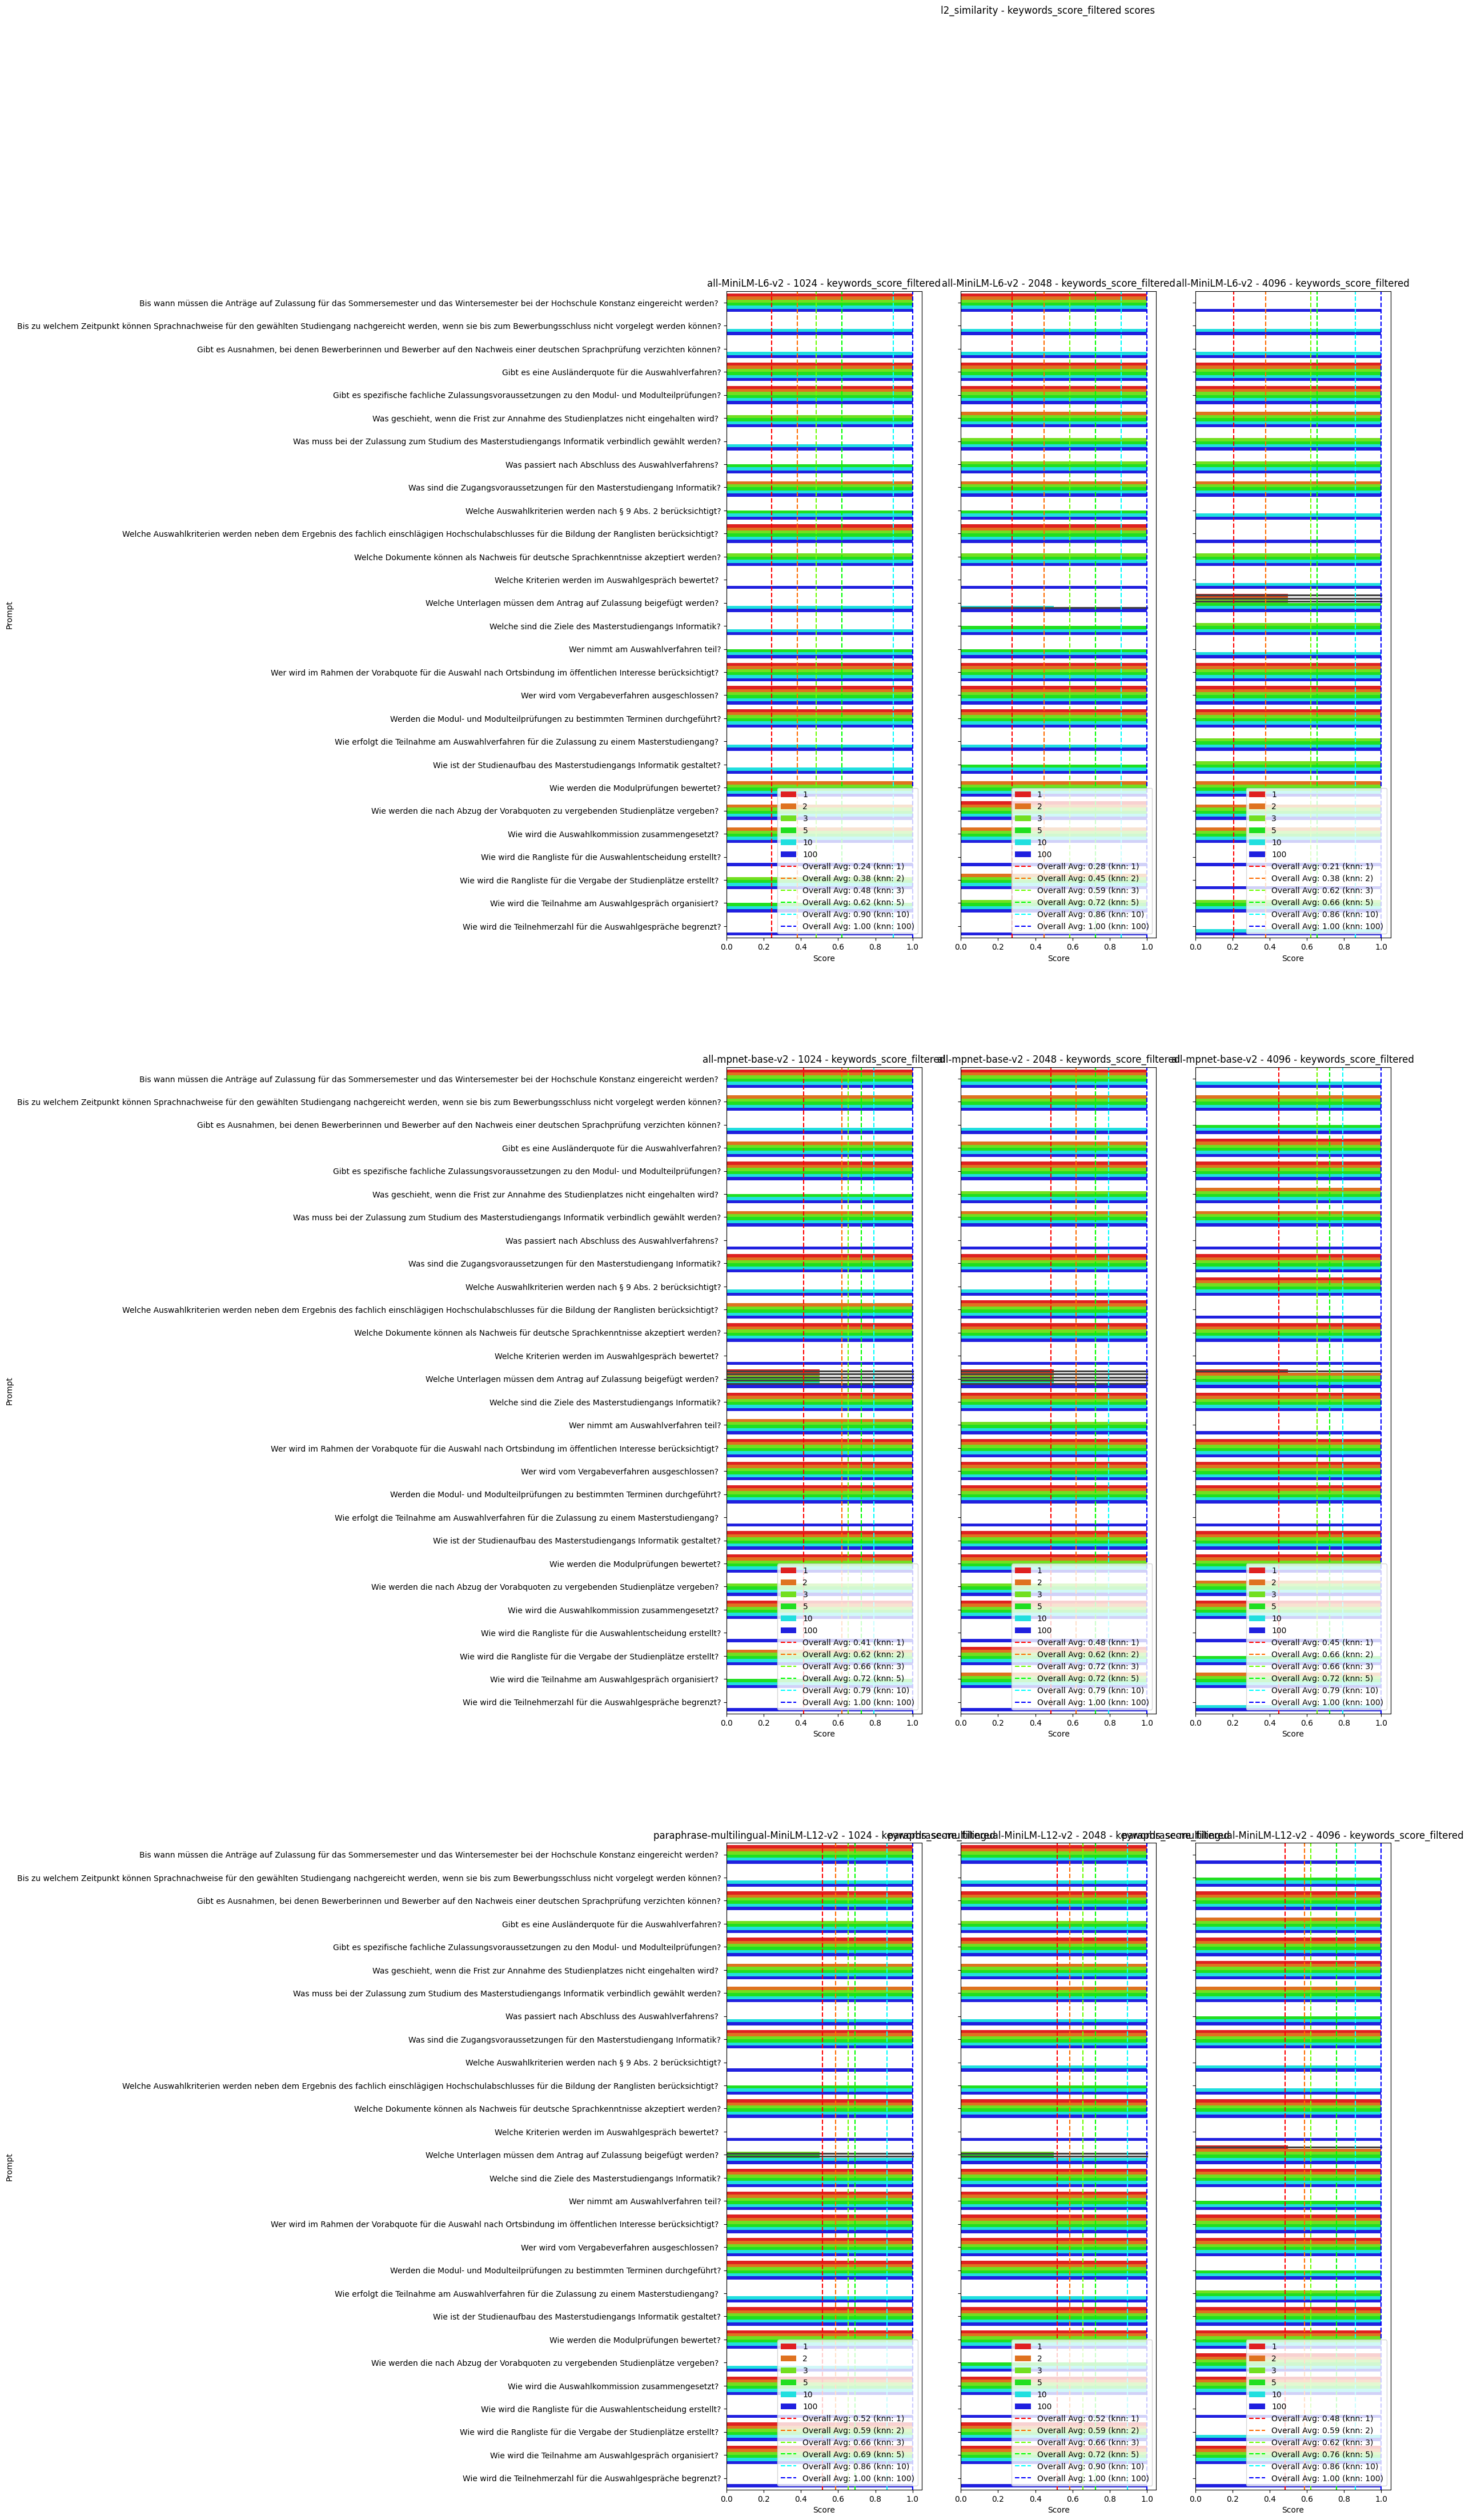

In [3]:
custom_colors = [(1.0, 0.0, 0.0),  # RGB values for the bars
                 (0.7, 0.3, 0.0),
                 (0.3, 0.7, 0.0),
                 (0.0, 1.0, 0.0),
                 (0.0, 0.5, 0.5),
                 (0.0, 0.0, 1.0)] 

# Convert RGB values to hex format
hex_colors = [sns.set_hls_values(color, l=0.5) for color in custom_colors]

# Create custom color palette
custom_palette = sns.color_palette(hex_colors)

def create_plots(df, metric, title: str):
    df = df[df['metric'] == metric]
    # sort by embedding model and chunk size
    _df = df.sort_values(by=['embedding_model', 'chunk_size'], ascending=[True, True])
    sorted_embedding_models = _df['embedding_model'].unique().tolist()
    # dict with the embedding model as key and a empty dict as value
    dict_embedding_models = {model: {} for model in sorted_embedding_models}
    unique_knns = _df['knn'].unique()
    for model in sorted_embedding_models:
        model_df = _df[_df['embedding_model'] == model]
        for knn in unique_knns:
            knn_df = model_df[model_df['knn'] == knn]
            chunk_sizes = knn_df['chunk_size'].unique()
            dict_embedding_models[model][knn] = {}
            for chunk_size in chunk_sizes:
                chunk_size_df = knn_df[knn_df['chunk_size'] == chunk_size]
                provider_ids = chunk_size_df['provider_id'].unique()
                dict_embedding_models[model][knn][str(chunk_size)] = provider_ids[0]
    
    sorted_knn = sorted(unique_knns)

    ## create a bar plot for each embedding model and chunk size
    fig, ax = plt.subplots(len(sorted_embedding_models), len(chunk_sizes), figsize=(15, 50))
    fig.suptitle(f'{title} - {metric} scores')

    for embedding_model in sorted_embedding_models:
        _df = df[df['embedding_model'] == embedding_model]
        _df = _df[_df['metric'] == metric]
        _df = _df.sort_values(by=['test_id', 'single_test_score'], ascending=[True, False])
        _df = _df.drop_duplicates(subset='test_id', keep='first')
        # sort df by question
        _df = _df.sort_values(by='prompt', ascending=True)

        # sort chunk sizes by ascending order
        sorted_chunk_sizes = sorted(_df['chunk_size'].unique())
        for chunk_size in sorted(_df['chunk_size'].unique()):
            chunk_size_df = _df[_df['chunk_size'] == chunk_size]
            
            ax_x = sorted_chunk_sizes.index(chunk_size)

            ax_y = sorted_embedding_models.index(embedding_model)

            if len(ax.shape) == 1:
                cur_ax = ax[ax_y]
            else:
                cur_ax = ax[ax_y, ax_x]

            cur_ax = sns.barplot(x='single_test_score', y='prompt', hue='knn', data=chunk_size_df, ax=cur_ax, palette=custom_palette)
            cur_ax.set_title(f'{embedding_model} - {chunk_size} - {metric}')
            cur_ax.set_xlabel('Score')
            cur_ax.set_ylabel('Prompt')
            if ax_x == 0:
                cur_ax.set_ylabel('Prompt')
            else:
                cur_ax.set_ylabel('')
                cur_ax.set_yticklabels([]) 
            # display the overall average score for each knn 
            for color_idx, knn in enumerate(sorted_knn):
                knn_df = chunk_size_df[chunk_size_df['knn'] == knn]
                overall_avg = knn_df['single_test_score'].mean()
                cur_ax.axvline(x=overall_avg, color=custom_palette[color_idx], linestyle='--', label=f'Overall Avg: {overall_avg:.2f} (knn: {knn})')
            
                cur_ax.legend(loc='lower right')
            if savefig:
                plt.savefig(f'{metric}_scores.svg', bbox_inches='tight')
    plt.show()

    ## create a kdplot for each embedding model and chunk size
    #fig, ax = plt.subplots(len(sorted_embedding_models), len(chunk_sizes), figsize=(15, 50))
    #fig.suptitle(f'{metric} scores')
    #for embedding_model in sorted_embedding_models:
    #    _df = df[df['embedding_model'] == embedding_model]
    #    _df = _df[_df['metric'] == metric]
    #    _df = _df.sort_values(by=['test_id', 'single_test_score'], ascending=[True, False])
    #    _df = _df.drop_duplicates(subset='test_id', keep='first')
    #    # sort df by question
    #    _df = _df.sort_values(by='prompt', ascending=True)
    #    # sort chunk sizes by ascending order
    #    sorted_chunk_sizes = sorted(_df['chunk_size'].unique())
    #    for chunk_size in sorted(_df['chunk_size'].unique()):
    #        chunk_size_df = _df[_df['chunk_size'] == chunk_size]
    #        
    #        ax_x = sorted_chunk_sizes.index(chunk_size)
    #        ax_y = sorted_embedding_models.index(embedding_model)
    #        ax[ax_y, ax_x] = sns.kdeplot(data=chunk_size_df, x='single_test_score', hue='knn', ax=ax[ax_y, ax_x], fill=True, palette=custom_palette)
    #        ax[ax_y, ax_x].set_title(f'{embedding_model} - {chunk_size} - {metric}')
    #        ax[ax_y, ax_x].set_xlabel('Score')
    #        ax[ax_y, ax_x].set_ylabel('Density')
    #        if ax_x == 0:
    #            ax[ax_y, ax_x].set_ylabel('Density')
    #        else:
    #            ax[ax_y, ax_x].set_ylabel('')
    #            ax[ax_y, ax_x].set_yticklabels([]) 
    #        if savefig:
    #            plt.savefig(f'{metric}_kdeplot.svg', bbox_inches='tight')
#
    #plt.show()

    # create a violin plot for each embedding model and chunk size. The left half of the violin is for context size 1024 and the right half is for context size 2048
    #fig, ax = plt.subplots(len(sorted_embedding_models), len(chunk_sizes), figsize=(15, 50))
    #fig.suptitle(f'{metric} scores')

    # summize the scores for each promp
    promps = df['prompt'].unique()
    prompt_scores = {}
    for prompt in promps:
        prompt_df = df[df['prompt'] == prompt]
        prompt_scores[prompt] = prompt_df['single_test_score'].sum()



#for metric in df['metric'].unique():
#   create_plots(df, metric)
for key in dfs.keys():
    df = dfs[key]
    create_plots(df, 'keywords_score_filtered', key)



In [23]:
json_data = json.load(open('/home/tpllmws23/Chatbot-LLama-Pruefungsamt/Chatbot-Jan/tests/_input/test_data.json'))

# Iterate over the dataframe
for index, row in df.iterrows():
    prompt = row['prompt']

    # Search in the JSON data for matching text
    for test in json_data['tests']:
        for question in test['questions']:
            if question['text'] == prompt:
                # Update the quality fields
                df.at[index, 'quality_specificity'] = question['quality']['specificity']
                df.at[index, 'quality_relevance'] = question['quality']['relevance']



/tmp/ipykernel_2861548/2505186890.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_data, y=y_labels, palette=htwg_colors, ax=ax)
/tmp/ipykernel_2861548/2505186890.py:35: UserWarning: 
The palette list has fewer values (1) than needed (28) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=x_data, y=y_labels, palette=htwg_colors, ax=ax)


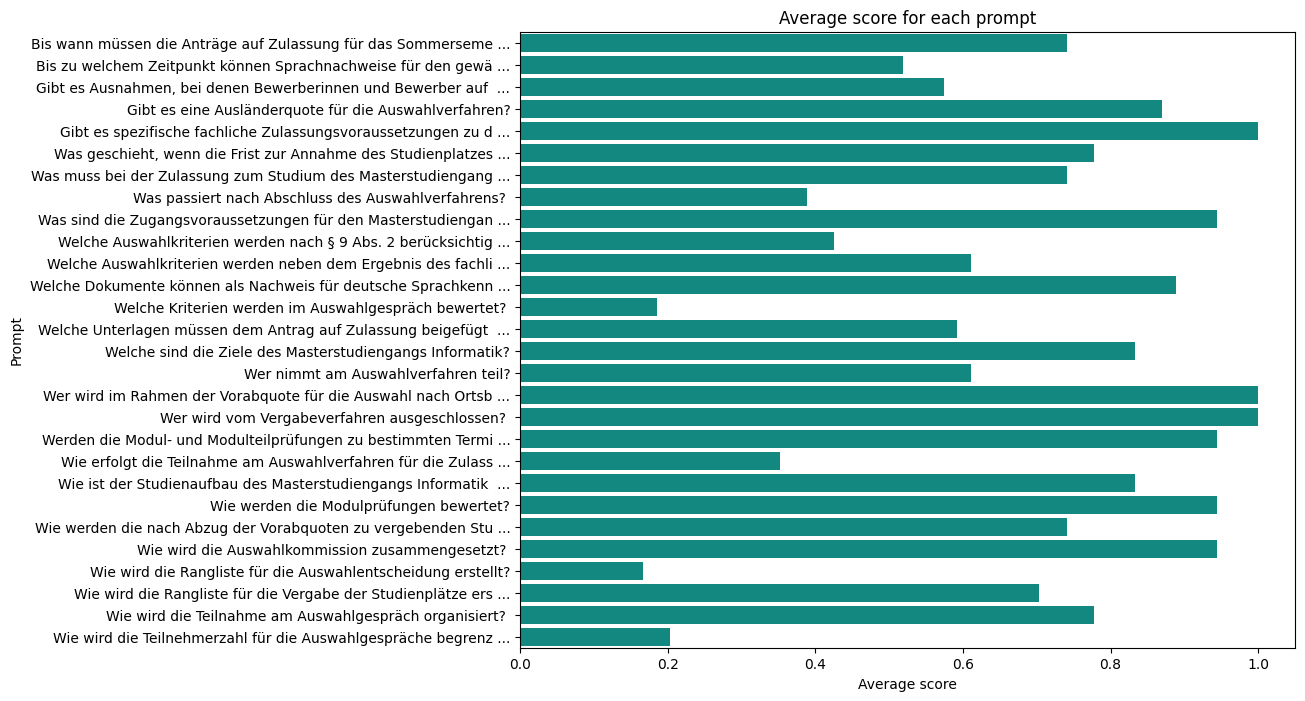

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# HTWG Konstanz Farben
htwg_colors = ['#009b91']  # Dunkelblau und Orange

# Funktion zum Kürzen von Texten
def shorten_label(label, max_length=60):
    return (label[:max_length] + ' ...') if len(label) > max_length else label

_df = df[df['metric'] == 'keywords_score_filtered']
_df = _df.sort_values(by=['test_id', 'single_test_score'], ascending=[True, False])
_df = _df.drop_duplicates(subset='test_id', keep='first')

prompts = _df['prompt'].unique()
prompt_scores = {}
for prompt in prompts:
    prompt_df = _df[_df['prompt'] == prompt]
    test_score = prompt_df['single_test_score']
    prompt_scores[prompt] = {
        'avg': test_score.mean(),
        'sum': test_score.sum(),
        'count': test_score.count(),
        'min': test_score.min(),
        # 'specificity': prompt_df['quality_specificity'].mean(),
    }

# sort the prompt_scores by the keys
prompt_scores = dict(sorted(prompt_scores.items()))
# create a bar plot for the prompt_scores. The x-axis is the score and the y-axis is the prompt.
x_data = [prompt_scores[prompt]['avg'] for prompt in prompt_scores]
y_labels = [shorten_label(prompt) for prompt in prompt_scores.keys()]

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=x_data, y=y_labels, palette=htwg_colors, ax=ax)
ax.set_title('Average score for each prompt')
ax.set_xlabel('Average score')
ax.set_ylabel('Prompt')
if True:
    plt.savefig('average_score_for_each_prompt.svg', bbox_inches='tight')
plt.show()

# Histogram

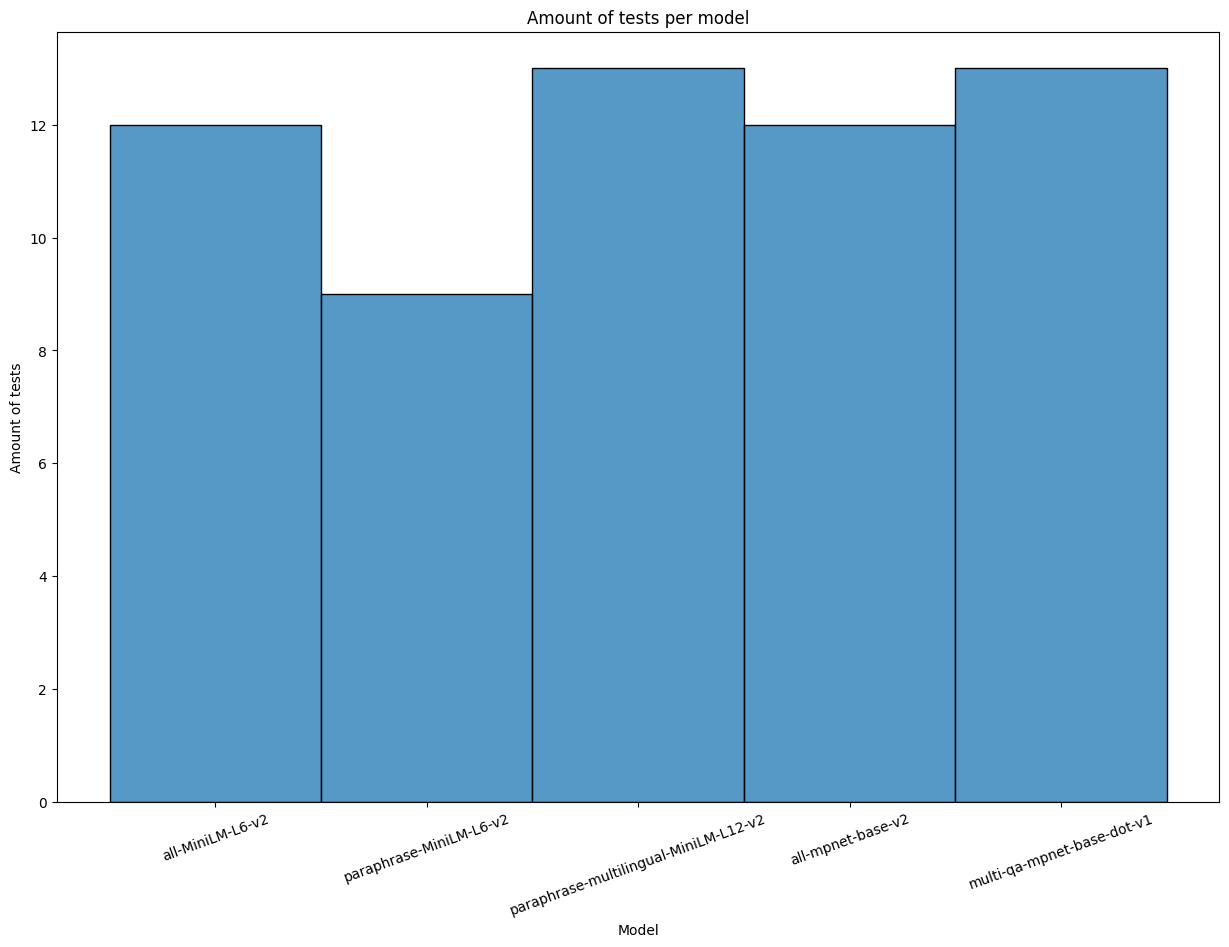

In [2]:
# group the tests in with the cosine_similarity by test_id and store the entries with the highest score per group
df_best_tests = pd.DataFrame()

groups = test_per_metric['keywords_score'].groupby('test_id')
for name, group in groups:
    # get the row with the highest keywords_score. if there are multiple rows with the same score, use the first one
    best_row = group[group['document_score'] == group['document_score'].max()].iloc[0]
    df_best_tests = df_best_tests.combine_first(pd.DataFrame([best_row]))
    

# get results where the keywords_score is 0
df_no_keywords = df_best_tests[df_best_tests['document_score'] == 0]
df_some_keywords = df_best_tests[df_best_tests['document_score'] > 0]

# create a histogram which shows how often a model had some keywords (blue) and put the amount of no keywords (orange) on top of the bars
plt.figure(figsize=(15, 10))
sns.histplot(data=df_some_keywords, x='embedding_model', bins=10, discrete=True)
plt.title('Amount of tests per model')
plt.xlabel('Model')
plt.ylabel('Amount of tests')
plt.xticks(rotation=20)
if savefig:
    plt.savefig('hist_all_tests.png')




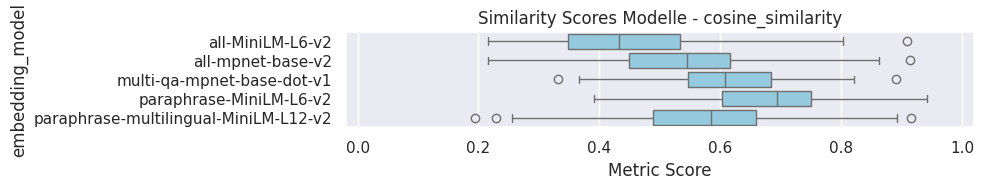

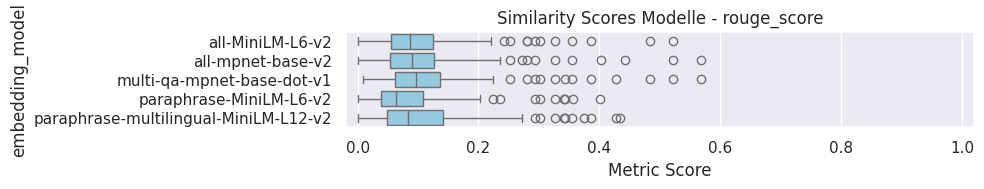

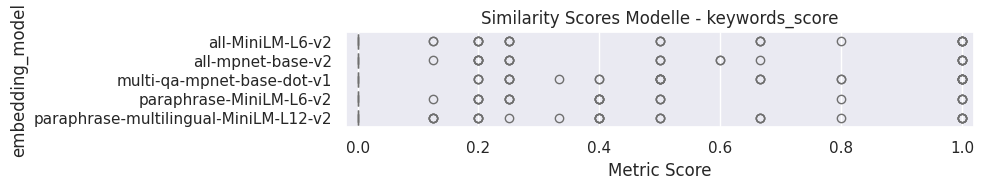

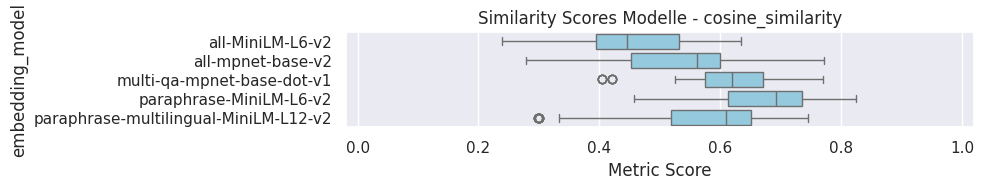

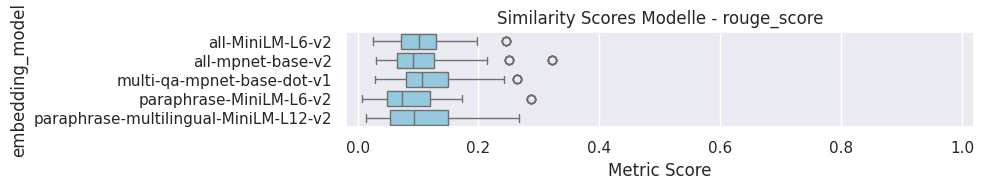

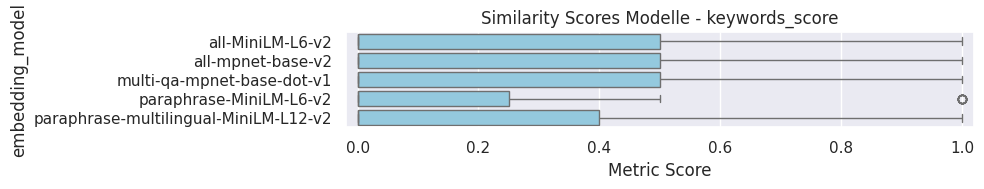

In [3]:
df_sorded_by_model = df_best_tests.sort_values(by='embedding_model')
unique_models = sorted(df['embedding_model'].unique())

unique_metrics = df['metric'].unique()


sns.set_theme()

for metric in unique_metrics:
    metric_data = df[df['metric'] == metric]
    
    plt.figure(figsize=(10, 6.5))
    
    plt.subplot(4, 1, 1)
    sns.boxplot(data=metric_data, x='document_score', y='embedding_model', color='skyblue', order=unique_models)
    plt.xlabel('Metric Score')
    plt.title(f'Similarity Scores Modelle - {metric}')
    plt.xlim(-0.02, 1.02) 
    
    plt.subplots_adjust(hspace=100)

    # Plotten
    plt.tight_layout()
    plt.show()

for metric in unique_metrics:
    metric_data = df[df['metric'] == metric]
    
    plt.figure(figsize=(10, 6.5))
    
    plt.subplot(4, 1, 1)
    sns.boxplot(data=metric_data, x='avg_score', y='embedding_model', color='skyblue', order=unique_models)
    plt.xlabel('Metric Score')
    plt.title(f'Similarity Scores Modelle - {metric}')
    plt.xlim(-0.02, 1.02) 
    
    plt.subplots_adjust(hspace=100)

    # Plotten
    plt.tight_layout()
    plt.show()


In [23]:
def plot_cosine_scores(df: pd.DataFrame):
    #############################################
    # Distribution of avg_score across all data #
    #############################################
    plt.figure(figsize=(10, 6))
    sns.histplot(df['avg_score'], kde=True, color='skyblue')
    plt.title('Distribution of avg_score')
    plt.xlabel('Average Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    if savefig:
        plt.savefig('images/svg/avg_score_distribution.svg')
        plt.savefig('images/png/avg_score_distribution.png')
    else:
        plt.show()

    #############################################################
    # Comparison of avg_score across different embedding_models #
    #############################################################
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='embedding_model', y='avg_score')
    plt.title('Comparison of avg_score across different embedding_models')
    plt.xlabel('Embedding Model')
    plt.ylabel('Average Score')
    plt.xticks(rotation=45)
    plt.grid(True)
    if savefig:
        plt.savefig('images/svg/avg_score_comparison.svg')
        plt.savefig('images/png/avg_score_comparison.png')
    else:
        plt.show()

    #################################################################################
    # Create a single plot with vertical density functions for each embedding_model #
    #################################################################################
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))
    for model in df['embedding_model'].unique():
        label = model.split('/')[-1]
        sns.kdeplot(data=df[df['embedding_model'] == model]['avg_score'], label=label, fill=True, palette=palette)
    plt.title('Density of avg_score for each embedding_model')
    plt.xlabel('Average Score')
    plt.ylabel('Density')
    plt.legend(title='Embedding Model')

    if savefig:
        plt.savefig('images/svg/avg_score_density.svg')
        plt.savefig('images/png/avg_score_density.png')
    else:
        plt.show()

    #########################################################
    # create a scatter plot of avg_score and document_score #
    #########################################################
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='avg_score', y='document_score', hue='embedding_model', palette=palette)
    plt.title('Comparison of avg_score and document_score')
    plt.xlabel('Average Score')
    plt.ylabel('Document Score')
    plt.grid(True)
    if savefig:
        plt.savefig('images/svg/score_comparison.svg')
        plt.savefig('images/png/score_comparison.png')
    else:
        plt.show()

for metric in 
plot_cosine_scores(best_document_per_search_df)

NameError: name 'best_document_per_search_df' is not defined

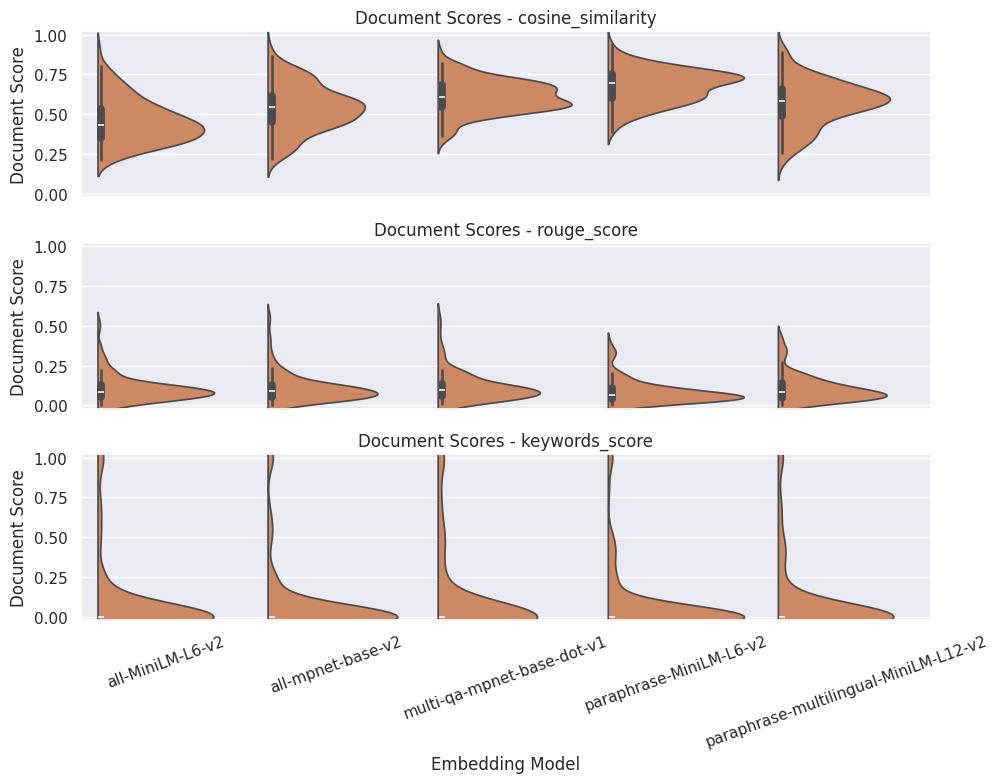

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

for i, metric in enumerate(unique_metrics):
    metric_data = df[df['metric'] == metric]

    plt.subplot(3, 1, i + 1)

    ax = sns.violinplot(
        data=metric_data,
        x="embedding_model", y="document_score", hue=True,
        hue_order=[False, True], split=True, order=unique_models
    )

    ax.legend_ = None
    if i != unique_metrics.size - 1:
        ax.set_xticklabels([])
    # set y-axis to a range from 0 to 1
    plt.ylim(-0.02, 1.02)
    plt.title(f'Document Scores - {metric}')
    plt.ylabel('Document Score')
    # rotate x-axis labels
    plt.xticks(rotation=20)

    if i == len(unique_metrics) - 1:
        plt.xlabel('Embedding Model')  # Set x-label only for the bottom subplot
    else:
        plt.xlabel('')  # Hide x-labels for other subplots

    plt.subplots_adjust(hspace=0.5)

    # Plotten
    plt.tight_layout()
    
plt.show()
